# Lesson 0042 - Art Generation
In [lesson 0041](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0041_mnist_autoencoder.ipynb) we created an __autoencoder__ for the [MNIST data set](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0010_mnist_classification_linear_classifier.ipynb).<br>
In this lesson, we want to create an __autoencoder__ to create art. We create this __autoencoder__ using the images from [train_1.zip](https://www.kaggle.com/c/painter-by-numbers/data). Since I ran into problems with big images, I deleted images bigger than $2$ MB. Also, I preselected images that contain people.<br>
We start with stealing code from [lesson 0041](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0041_mnist_autoencoder.ipynb).

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [3]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [4]:
import keras
from keras import models
from keras import layers
from keras.preprocessing.image import img_to_array as ita



print( keras.__version__ )

2.2.4


Using TensorFlow backend.


Now, we steal code from [lesson 0038](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0038_botticelli_kandinsky_image_style_transfer.ipynb).

In [5]:
from PIL import Image

print( Image.__version__ )

5.4.1


We turn the warning for [Decmpression Bombs off](https://pillow.readthedocs.io/en/5.1.x/releasenotes/5.0.0.html).<br>
Also, we [load truncated images](https://github.com/keras-team/keras/issues/5475#issuecomment-281888485).

In [6]:
Image.MAX_IMAGE_PIXELS = None

Image.LOAD_TRUNCATED_IMAGES = True

Now, we import __os__ for opening of the folder where the art lies.

In [7]:
import os

We now use [listdir](https://docs.python.org/3/library/os.html) to get all the files in the folder.

In [8]:
folder = 'C:\\Users\\rhopi\\OneDrive\\Desktop\\python dev\\github\\lesson_0042\\train_1\\'



number_of_images = 0



for img in os.listdir( folder ):
    
    number_of_images = number_of_images + 1
    
    
    
print( number_of_images )   

2008


Now, we create storage for the images. We will shrink them to $50 * 50$ pixels.

In [9]:
train = np.zeros( shape = [ 2008, 50, 50, 3 ], dtype = np.float32 )




i = 0




for img in os.listdir( folder ):
    
    path_img = folder + img
    
    current = Image.open( path_img )
    
    
    
    
    width, height = current.size
    
    
    
    
    if width > height:
        
        width_new = 50
        
        height_new = np.int( np.float( height ) / np.float( width ) * 50 )
        
    else:
        
        height_new = 50
        
        width_new = np.int( np.float( width ) / np.float( height ) * 50 )
        
        
    
    
    current = current.resize( ( width_new, height_new ), resample = Image.BILINEAR )
    
    
    
    
    insert = ita( current )
    
    
    
    
    train[ i, 0 : height_new, 0 : width_new, : ] = insert[ :, :, 0 : 3 ]
    
    
    
    
    i = i + 1
    
    current.close()

In [10]:
mu = np.mean( train )

std = np.std( train )



train = ( train - mu ) / std

Now, we build the __encoder__.

In [11]:
input_encoder = keras.engine.input_layer.Input( shape = ( 50, 50, 3, ) )

encoder_layer1 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_encoder )

encoder_layer2 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer1 )

encoder_layer3 = layers.MaxPooling2D()( encoder_layer2 )

encoder_layer4 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer3 )

encoder_layer5 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer4 )

encoder_layer6 = layers.MaxPooling2D()( encoder_layer5 )

encoder_layer7 = layers.Flatten()( encoder_layer6 )

encoder_layer8 = layers.Dense( 128, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer7 )

encoder = keras.Model( input_encoder, encoder_layer8 )

encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        102464    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        102464    
_________________________________________________________________
max_

C:\Users\rhopi\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


And here comes the __decoder__.

In [12]:
input_decoder = keras.engine.input_layer.Input( shape = ( 128, ) )

decoder_layer1 = layers.Dense( 50 * 50, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_decoder )

decoder_layer2 = layers.Reshape( ( 50, 50, 1, ) )( decoder_layer1 )

decoder_layer3 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer2 )

decoder_layer4 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer3 )

decoder_layer5 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer4 )

decoder_layer6 = layers.Conv2D( 3, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer5 )

decoder = keras.Model( input_decoder, decoder_layer6 )

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2500)              322500    
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        1664      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 64)        102464    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 64)        102464    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 3)         4803      
Total para

And here comes the __autoencoder__.

In [13]:
autoencoder = keras.Model( input_encoder, decoder( encoder( input_encoder ) ) )

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
model_1 (Model)              (None, 128)               607296    
_________________________________________________________________
model_2 (Model)              (None, 50, 50, 3)         533895    
Total params: 1,141,191
Trainable params: 1,141,191
Non-trainable params: 0
_________________________________________________________________


So, our __autoencoder__ takes a $50*50*3$ image, reduces it to $128$ numbers, and then maps it back to $50*50*3$. Thereby the __autoencoder__ compresses an image to less than $2\%$.<br>
During optimization, we employ a [decay](https://keras.io/optimizers/) of the learning rate. This means, that during the learning process, the learning rate is reduced. We do this, because if the learning rate is too high, we will overshoot the local optimum. And the problem with overshooting arises late in the optimization process, since late in the optimization process, one is usually close to the optimum. The __decay__ is chosen to be the __learning rate__ divided by the number of epochs [as suggested here](https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/).<br>
We also apply [clipnorm](https://keras.io/optimizers/): the idea is to normalize the gradient to a (euclidian) norm of $1$. We do this in order to prevent the gradient from exploding to great values which may destroy the learning progress.<br>
Also, we use a __batch_size__ of $5$. We do this, because small batch sizes have two consequences: on the one hand, the batch size is directly translated to the number of gradients that are computed during one epoch. Therefore, a small batch size means, that there are more updates of weights in the network during one epoch. On the other hand, the greater the batch size, the more the gradient that is computed using a batch will be the gradient of the complete training set. Therefore, smaller batches will have noisier gradients, and therefore the likelihood of getting stuck in local optima is reduced.

In [14]:
autoencoder.compile( optimizer = keras.optimizers.SGD( lr = 0.1, momentum = 0.0, decay = 0.1 / 5000, nesterov = False, 
                                                      clipnorm = 1.0 ),
               loss = "mean_squared_error", metrics = None )

autoencoder.fit( train, train, batch_size = 5, epochs = 5000 )

Instructions for updating:
Use tf.cast instead.
Epoch 1/5000
2008/2008 [==============================] - 9s 4ms/step - loss: 0.7658
Epoch 2/5000
2008/2008 [==============================] - 4s 2ms/step - loss: 0.3878
Epoch 3/5000
2008/2008 [==============================] - 4s 2ms/step - loss: 0.2856
Epoch 4/5000
2008/2008 [==============================] - 4s 2ms/step - loss: 0.2442
Epoch 5/5000
2008/2008 [==============================] - 4s 2ms/step - loss: 0.2212
Epoch 6/5000
2008/2008 [==============================] - 4s 2ms/step - loss: 0.2057
Epoch 7/5000
2008/2008 [==============================] - 4s 2ms/step - loss: 0.1942
Epoch 8/5000
2008/2008 [==============================] - 4s 2ms/step - loss: 0.1844
Epoch 9/5000
2008/2008 [==============================] - 4s 2ms/step - loss: 0.1760
Epoch 10/5000
2008/2008 [==============================] - 4s 2ms/step - loss: 0.1695
Epoch 11/5000
2008/2008 [==============================] - 4s 2ms/step - loss: 0.1641
Epoch 12/5000
2

Now, we use the __encoder__ to predict the compression of the first $2000$ images in the __train__ set. We then compute for each of the $128$ dimensions its mean and standard deviation as well as the minimum and the maximum value.

In [15]:
data = np.zeros( shape = [ 2000, 128 ] )

mud = np.zeros( shape = [ 128 ] )

stdd = np.zeros( shape = [ 128 ] )

a_min = np.zeros( shape = [ 128 ] )

a_max = np.zeros( shape = [ 128 ] )





for i in range( 2000 ):
    
    p = encoder.predict( [ train[ i, :, :, : ].reshape( [ 1, 50, 50, 3 ] ) ] )
    
    data[ i, : ] = p
        
        
        
for i in range( 128 ):
    
    mud[ i ] = np.mean( data[ :, i ] )
    
    stdd[ i ] = np.std( data[ :, i ] )
    
    a_min[ i ] = np.min( data[ :, i ] )
    
    a_max[ i ] = np.max( data[ :, i ] )

Next, we plot the first $5$ images from the __train__ set. First, we print the original image, and then the original image processed by the __autoencoder__.

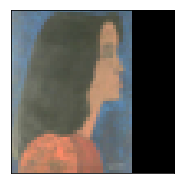

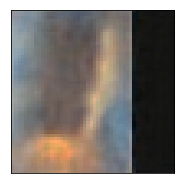

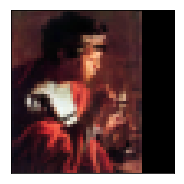

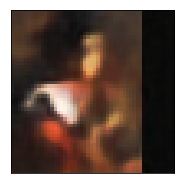

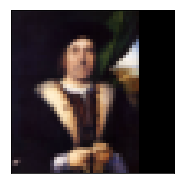

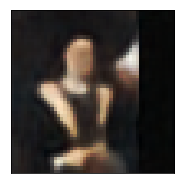

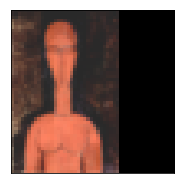

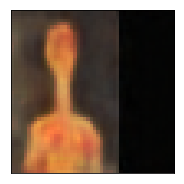

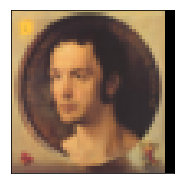

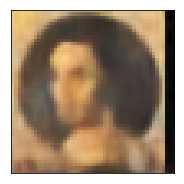

In [16]:
for i in range( 5 ):
    
    img = train[ i, :, :, : ]
    
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )    
    
    
    
    
    
    
    img = autoencoder.predict( [ train[ i, :, :, : ].reshape( [ 1, 50, 50, 3 ] ) ] )[ 0 ]
    
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

We see, that the __autoencoder__ is able to preserve basic features of the images, but obviously, finer details get lost. But since we compress the images to less than $2\%$, the result is actually good.<br>
Now, that the training is done, we print some randomly generated images.<br>
We employ [randn](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randn.html) to generate random data that are normally distributed with mean $0$ and standard deviation of $1$. Using the means and the standard deviations computed above, we map the numbers to random numbers in the same intervals as produced by the __train__ set. Since neural networks are good at interpolation, but bad a extrapolation, we [clip](https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html) these random numbers to be within the minimum and the maximum of each dimension.<br>
We then employ the __decoder__ to predict images using these random numbers:

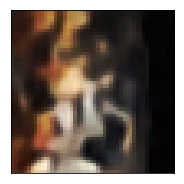

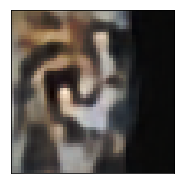

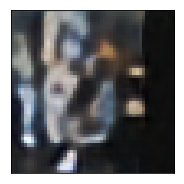

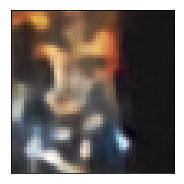

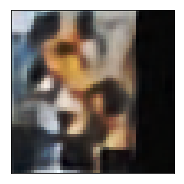

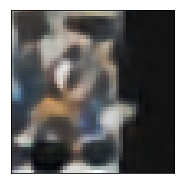

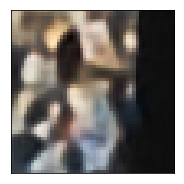

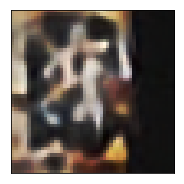

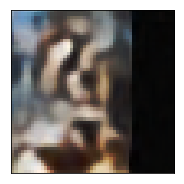

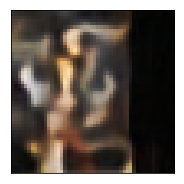

In [17]:
for i in range( 10 ):
    
    random_vector = stdd * np.random.randn( 1, 128 ) + mud
    
    random_vector = np.clip( random_vector, a_min = a_min, a_max = a_max )
    
    
    
        
    img = decoder.predict( random_vector )[ 0 ]
        
        
        
        
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

These images all look very abstract. Let's repeat this, but this time, we reduce the variance of the random numbers.

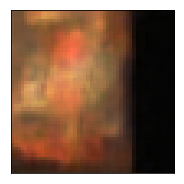

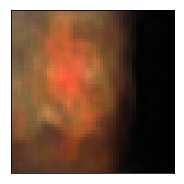

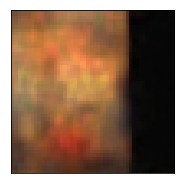

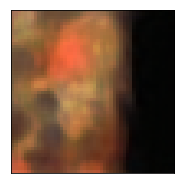

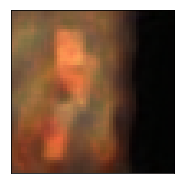

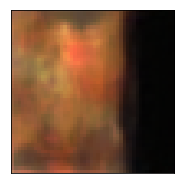

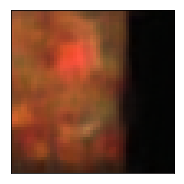

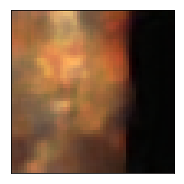

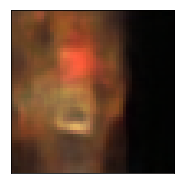

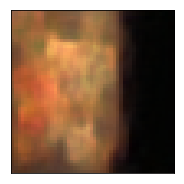

In [18]:
for i in range( 10 ):
    
    random_vector = stdd * 0.3 * np.random.randn( 1, 128 ) + mud
    
    random_vector = np.clip( random_vector, a_min = a_min, a_max = a_max )
    
    
    
        
    img = decoder.predict( random_vector )[ 0 ]
        
        
        
        
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

In the fifth image, one might be able to see a person, but all is very blurry. Let's further reduce the randomness.

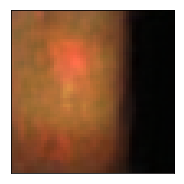

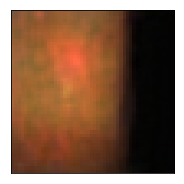

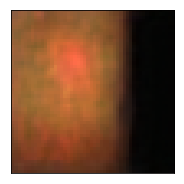

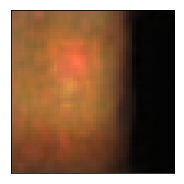

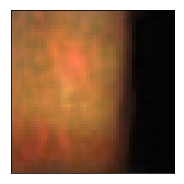

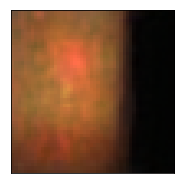

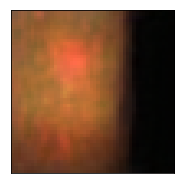

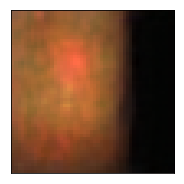

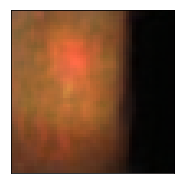

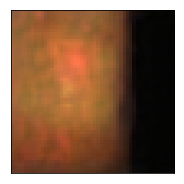

In [19]:
for i in range( 10 ):
    
    random_vector = stdd * 0.05 * np.random.randn( 1, 128 ) + mud
    
    random_vector = np.clip( random_vector, a_min = a_min, a_max = a_max )
    
    
    
        
    img = decoder.predict( random_vector )[ 0 ]
        
        
        
        
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

Now evertything looks the same. Let's increse the randomness.

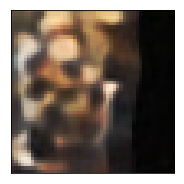

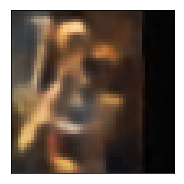

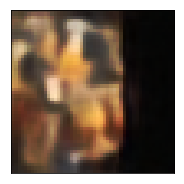

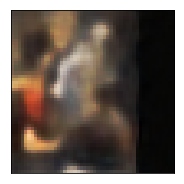

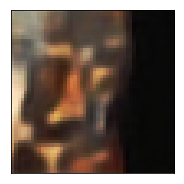

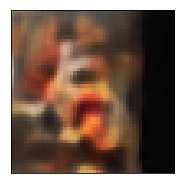

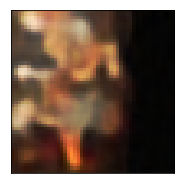

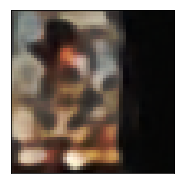

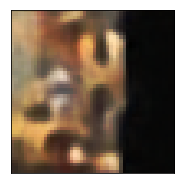

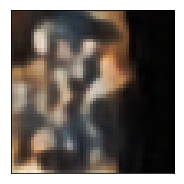

In [20]:
for i in range( 10 ):
    
    random_vector = stdd * 0.7 * np.random.randn( 1, 128 ) + mud
    
    random_vector = np.clip( random_vector, a_min = a_min, a_max = a_max )
    
    
    
        
    img = decoder.predict( random_vector )[ 0 ]
        
        
        
        
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

Here, we have very abstract images, let's reduce the randomness a tiny bit.

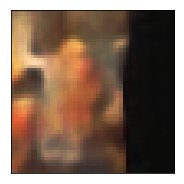

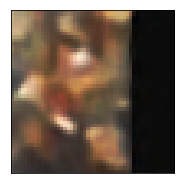

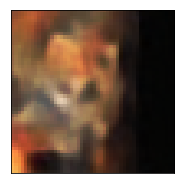

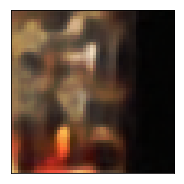

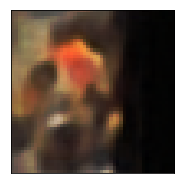

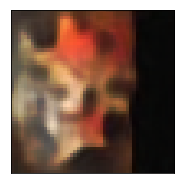

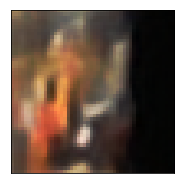

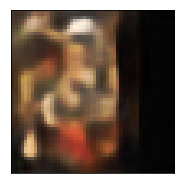

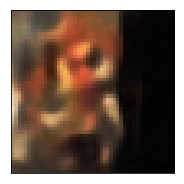

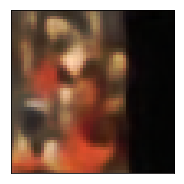

In [21]:
for i in range( 10 ):
    
    random_vector = stdd * 0.6 * np.random.randn( 1, 128 ) + mud
    
    random_vector = np.clip( random_vector, a_min = a_min, a_max = a_max )
    
    
    
        
    img = decoder.predict( random_vector )[ 0 ]
        
        
        
        
    img = img * std + mu
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

Now, we have in the first, the eigth and the last image blurry figures that have some similarity to people.<br>
Let's close this session. In future sessions, we might ponder how we can reduce the noise in the images.<br>
Class dismissed.